# Traits Content-based NFT Recommender System

https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

Check this later (not that different): https://medium.com/dataseries/recommendation-system-in-python-4d4cf6d33166 , https://gist.github.com/deansublett/06f010a886831f9dac5b1f9bce4f4229?source=post_page---------------------------

In [ ]:
# !pip install rake-nltk

In [ ]:
import pandas as pd
# from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
# import nltk

# nltk.download('stopwords')
# from nltk.corpus import stopwords
# nltk.download('punkt')

## Get Dataset

In [ ]:
from google.colab import drive
drive.mount('drive')

assets_file_path = "/content/drive/MyDrive/Datasets/FYP/bayc-nft-assets"
original_df = pd.read_csv(assets_file_path, sep='\t')

# df = df[['nft_id','traits_string','asset_contract_address', 'total_rarity']]
original_df.head()

Mounted at drive


,nft_id,name,asset_description,asset_contract_address,collection_name,collection_description,collection_slug,collection_verification,creator_username,creator_address,...,owner_profile_img_url,traits_string,total_rarity,num_sales,last_sale_timestamp,last_sale_total_price,last_sale_from_account_address,top_bid,open_sea_link,image_url
0,9974,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeseyepatch;;hatseaman'shat;;clothesrainbowsu...,204.051791,2,2021-05-09T16:46:27,500000000000000000,0x994cf01f34c51426bcb12bd30ff7079e280e1140,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/G60LFd7Xhb4-...
1,9973,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,furdmt;;hatgirl'shairpink;;eyesrobot;;backgrou...,182.516792,1,2021-05-01T16:24:22,580000000000000000,0x078ad2aa3b4527e4996d087906b2a3da51bba122,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/-4Pz6B1FkH8k...
2,9949,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,mouthgringoldgrill;;furtan;;hatseaman'shat;;ey...,221.356456,7,2021-11-21T10:04:02,85800000000000000000,0x91e1543bf18cc3c7a25e682f9c20cf8bd6f28548,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/RcXAgekWgaH5...
3,9972,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeshypnotized;;mouthrage;;backgroundaquamarin...,149.528746,1,2021-05-01T11:03:09,150000000000000000,0x02eb75be1e72e988de64f0088d654d8ea1081e87,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/vcL_TRKR8FRq...
4,9948,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,hattrippycaptain'shat;;furcream;;eyesbloodshot...,268.580759,2,2021-05-03T02:45:55,1750000000000000000,0xecba5f51925e6ccec26da38dcd7d5305f6bdfbcb,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/jMsgIXhlR0Xe...


## Data Cleaning

In [ ]:
for index, row in original_df.iterrows():
    original_df.at[index,'reference_id'] = row["asset_contract_address"] + "-" + str(row["nft_id"])

df = original_df.copy(deep=True)

df['traits_string'] = df['traits_string'].str.replace(';;',' ')

df.head()

,nft_id,name,asset_description,asset_contract_address,collection_name,collection_description,collection_slug,collection_verification,creator_username,creator_address,...,traits_string,total_rarity,num_sales,last_sale_timestamp,last_sale_total_price,last_sale_from_account_address,top_bid,open_sea_link,image_url,reference_id
0,9974,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,eyeseyepatch hatseaman'shat clothesrainbowsusp...,204.051791,2,2021-05-09T16:46:27,500000000000000000,0x994cf01f34c51426bcb12bd30ff7079e280e1140,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/G60LFd7Xhb4-...,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9974
1,9973,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,furdmt hatgirl'shairpink eyesrobot backgroundy...,182.516792,1,2021-05-01T16:24:22,580000000000000000,0x078ad2aa3b4527e4996d087906b2a3da51bba122,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/-4Pz6B1FkH8k...,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9973
2,9949,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,mouthgringoldgrill furtan hatseaman'shat eyes3...,221.356456,7,2021-11-21T10:04:02,85800000000000000000,0x91e1543bf18cc3c7a25e682f9c20cf8bd6f28548,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/RcXAgekWgaH5...,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9949
3,9972,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,eyeshypnotized mouthrage backgroundaquamarine ...,149.528746,1,2021-05-01T11:03:09,150000000000000000,0x02eb75be1e72e988de64f0088d654d8ea1081e87,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/vcL_TRKR8FRq...,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9972
4,9948,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,hattrippycaptain'shat furcream eyesbloodshot m...,268.580759,2,2021-05-03T02:45:55,1750000000000000000,0xecba5f51925e6ccec26da38dcd7d5305f6bdfbcb,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/jMsgIXhlR0Xe...,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948


In [ ]:
df.iloc[0]

nft_id                                                                         9974
name                                                                            NaN
asset_description                                                               NaN
asset_contract_address                   0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
collection_name                                                Bored Ape Yacht Club
collection_description            The Bored Ape Yacht Club is a collection of 10...
collection_slug                                                   boredapeyachtclub
collection_verification                                                        True
creator_username                                                  BoredApeYachtClub
creator_address                          0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03
creator_profile_img_url           https://storage.googleapis.com/opensea-static/...
owner_username                                                              

In [ ]:
# Rake Vectorizer
# # initializing the new column
# df['Key_words'] = ""

# for index, row in df.iterrows():
#     plot = row['Plot']
    
#     # instantiating Rake, by default it uses english stopwords from NLTK
#     # and discards all puntuation characters as well
#     r = Rake()

#     # extracting the words by passing the text
#     r.extract_keywords_from_text(plot)

#     # getting the dictionary with key words as keys and their scores as values
#     key_words_dict_scores = r.get_word_degrees()
    
#     # assigning the key words to the new column for the corresponding nft
#     row['Key_words'] = list(key_words_dict_scores.keys())

# # dropping the Plot column
# df.drop(columns = ['Plot'], inplace = True)

# df.head()

In [ ]:
df.set_index('reference_id', inplace = True)   # set reference_id as the index of the dataframe
df.head()

,nft_id,name,asset_description,asset_contract_address,collection_name,collection_description,collection_slug,collection_verification,creator_username,creator_address,...,owner_profile_img_url,traits_string,total_rarity,num_sales,last_sale_timestamp,last_sale_total_price,last_sale_from_account_address,top_bid,open_sea_link,image_url
reference_id,,,,,,,,,,,,,,,,,,,,,
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9974,9974,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeseyepatch hatseaman'shat clothesrainbowsusp...,204.051791,2,2021-05-09T16:46:27,500000000000000000,0x994cf01f34c51426bcb12bd30ff7079e280e1140,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/G60LFd7Xhb4-...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9973,9973,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,furdmt hatgirl'shairpink eyesrobot backgroundy...,182.516792,1,2021-05-01T16:24:22,580000000000000000,0x078ad2aa3b4527e4996d087906b2a3da51bba122,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/-4Pz6B1FkH8k...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9949,9949,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,mouthgringoldgrill furtan hatseaman'shat eyes3...,221.356456,7,2021-11-21T10:04:02,85800000000000000000,0x91e1543bf18cc3c7a25e682f9c20cf8bd6f28548,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/RcXAgekWgaH5...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9972,9972,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeshypnotized mouthrage backgroundaquamarine ...,149.528746,1,2021-05-01T11:03:09,150000000000000000,0x02eb75be1e72e988de64f0088d654d8ea1081e87,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/vcL_TRKR8FRq...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948,9948,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,hattrippycaptain'shat furcream eyesbloodshot m...,268.580759,2,2021-05-03T02:45:55,1750000000000000000,0xecba5f51925e6ccec26da38dcd7d5305f6bdfbcb,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/jMsgIXhlR0Xe...


In [ ]:
original_df.set_index('reference_id', inplace = True)   # set reference_id as the index of the dataframe
original_df.head()

,nft_id,name,asset_description,asset_contract_address,collection_name,collection_description,collection_slug,collection_verification,creator_username,creator_address,...,owner_profile_img_url,traits_string,total_rarity,num_sales,last_sale_timestamp,last_sale_total_price,last_sale_from_account_address,top_bid,open_sea_link,image_url
reference_id,,,,,,,,,,,,,,,,,,,,,
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9974,9974,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeseyepatch;;hatseaman'shat;;clothesrainbowsu...,204.051791,2,2021-05-09T16:46:27,500000000000000000,0x994cf01f34c51426bcb12bd30ff7079e280e1140,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/G60LFd7Xhb4-...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9973,9973,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,furdmt;;hatgirl'shairpink;;eyesrobot;;backgrou...,182.516792,1,2021-05-01T16:24:22,580000000000000000,0x078ad2aa3b4527e4996d087906b2a3da51bba122,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/-4Pz6B1FkH8k...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9949,9949,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,mouthgringoldgrill;;furtan;;hatseaman'shat;;ey...,221.356456,7,2021-11-21T10:04:02,85800000000000000000,0x91e1543bf18cc3c7a25e682f9c20cf8bd6f28548,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/RcXAgekWgaH5...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9972,9972,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,eyeshypnotized;;mouthrage;;backgroundaquamarin...,149.528746,1,2021-05-01T11:03:09,150000000000000000,0x02eb75be1e72e988de64f0088d654d8ea1081e87,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/vcL_TRKR8FRq...
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948,9948,NaN,NaN,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,The Bored Ape Yacht Club is a collection of 10...,boredapeyachtclub,True,BoredApeYachtClub,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,...,https://storage.googleapis.com/opensea-static/...,hattrippycaptain'shat;;furcream;;eyesbloodshot...,268.580759,2,2021-05-03T02:45:55,1750000000000000000,0xecba5f51925e6ccec26da38dcd7d5305f6bdfbcb,NaN,https://opensea.io/assets/0xbc4ca0eda7647a8ab7...,https://lh3.googleusercontent.com/jMsgIXhlR0Xe...


In [ ]:
# df.drop(columns = [col for col in df.columns if ((col!= 'traits_string') or (col!= 'total_rarity'))], inplace = True)
df = df[['traits_string','total_rarity']]
df.head()

,traits_string,total_rarity
reference_id,,
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9974,eyeseyepatch hatseaman'shat clothesrainbowsusp...,204.051791
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9973,furdmt hatgirl'shairpink eyesrobot backgroundy...,182.516792
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9949,mouthgringoldgrill furtan hatseaman'shat eyes3...,221.356456
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9972,eyeshypnotized mouthrage backgroundaquamarine ...,149.528746
0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948,hattrippycaptain'shat furcream eyesbloodshot m...,268.580759


In [ ]:
df['traits_string'].count()
df['total_rarity'].count()

10000

## Modeling

In order to detect similarities between NFTs, I need to vectorize, as I mentioned above. I decided to use CountVectorizer rather than TfIdfVectorizer for one simple reason: I need a simple frequency counter for each word in my bag_of_words column. Tf-Idf tends to give less importance to the words that are more present in the entire corpus (our whole column, in this case) which is not what we want for this application, because every word is important to detect similarity! 

*It seems like Tf-Idf would give more meaningful results* for ranking - check this later. For relevance, CountVectorizer seems to be ok.

Once I have the matrix containing the count for each word, we can apply the cosine_similarity function

In [ ]:
# instantiating and generating the count matrix
count = CountVectorizer()   # used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text
count_matrix = count.fit_transform(df['traits_string'])

# print(count_matrix)
count_matrix.todense()

matrix([[1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 1],
        ...,
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
count_matrix.shape

(10000, 173)

in the count_matrix, i seems to be the NFT, j seems to be each word in the bag_of_words per NFT. the value at i, j gives the frequency of each word in the entire column of bag_of_words.

For some reason (need to find out) this frequency is needed to calculate the cosine similarity between the content in NFTs. - *The definition of similarity between two vectors u and v is, in fact, the ratio between their dot product and the product of their magnitudes.*

In [ ]:
# creating a Series for the reference_id so they are associated to an ordered numerical
# list I will use later to match the indexes - easy to refer the NFT by index from the array that is created (cosine_sim)
indices = pd.Series(df.index)
indices[:5]

0    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9974
1    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9973
2    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9949
3    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9972
4    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948
Name: reference_id, dtype: object

Check if this concern can be addressed: Having cosine_sim in-memory can be a memory constraint for larger datasets

In [ ]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
# cosine_sim.todense()

In [ ]:
# function that takes in reference_id as input and returns the top 10 recommended nfts
def content_based_recommendations(reference_id, cosine_sim = cosine_sim):
    
    recommended_nfts = []
    cosine_sim_scores_of_recommendations = []

    # getting the index of the NFT that matches the reference_id
    idx = indices[indices == reference_id].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar nfts
    top_10_indexes = list(score_series.iloc[1:11].index)
    # getting the cosine similarities of the 10 most similar nfts
    cosine_sim_scores_of_recommendations = list(score_series.iloc[1:11])
    
    # populating the list with the reference_ids of the best 10 matching nfts
    for i in top_10_indexes:
        recommended_nfts.append(list(df.index)[i])
        
    return recommended_nfts, cosine_sim_scores_of_recommendations

In [ ]:
def trait_rarity_recommendations(reference_id):

    recommended_nfts = []
    trait_rarity_scores_of_recommendations = []

    input = df.loc[reference_id]['total_rarity']
    # print("total_rarity of reference item", input)

    #  This considers the entire dataframe. Need to do this only within a collection - send the filtered dataframe as a parameter
    # the dataframe with 10 closest values.
    df_sort = df.iloc[(df['total_rarity']-input).abs().argsort()[1:11]]

    recommended_nfts = df_sort.index.tolist()
    trait_rarity_scores_of_recommendations = df_sort['total_rarity'].tolist()
    # print(df_sort['total_rarity'].tolist())

    return recommended_nfts, trait_rarity_scores_of_recommendations

In [ ]:
def create_cosine_rec_response(recommended_nfts_arr, cosine_sim_scores_of_recommendations_arr):

  # return the original data of the nft using the original_df dataframe (convert to an array of dictionaries and return)
  results_df = original_df.loc[recommended_nfts_arr]

  # append column with cosine_sim_scores
  for index, nft in enumerate(recommended_nfts_arr):
    # print(index)
    results_df.at[nft, 'cosine_sim'] = cosine_sim_scores_of_recommendations_arr[index]
  
  results_df = results_df.astype(object).where(pd.notnull(results_df),None)

  return results_df.to_dict('records')

In [ ]:
def create_rarity_rec_response(recommended_nfts_arr, total_rarity_scores_of_recommendations_arr):

  # return the original data of the nft using the original_df dataframe (convert to an array of dictionaries and return)
  results_df = original_df.loc[recommended_nfts_arr]

  # append column with total_rarity_scores
  for index, nft in enumerate(recommended_nfts_arr):
    # print(index)
    results_df.at[nft, 'total_rarity'] = total_rarity_scores_of_recommendations_arr[index]
  
  results_df = results_df.astype(object).where(pd.notnull(results_df),None)

  return results_df.to_dict('records')

## Testing

Recommendation based on content similarity of traits matches

In [ ]:
reference_item_id = '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948'

In [ ]:
content_based_recommendations(reference_item_id)

(['0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-7474',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-633',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-8279',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-6352',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-4343',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-5900',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-6706',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-791',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-5693',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-6248'],
 [0.5714285714285713,
  0.5714285714285713,
  0.5714285714285713,
  0.5714285714285713,
  0.5714285714285713,
  0.5714285714285713,
  0.5345224838248487,
  0.50709255283711,
  0.50709255283711,
  0.50709255283711])

In [ ]:
recommended_nfts_arr, cosine_sim_scores_of_recommendations_arr = content_based_recommendations(reference_item_id)

In [ ]:
create_cosine_rec_response(recommended_nfts_arr, cosine_sim_scores_of_recommendations_arr)

[{'asset_contract_address': '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d',
  'asset_description': None,
  'collection_description': 'The Bored Ape Yacht Club is a collection of 10,000 unique Bored Ape NFTs— unique digital collectibles living on the Ethereum blockchain. Your Bored Ape doubles as your Yacht Club membership card, and grants access to members-only benefits, the first of which is access to THE BATHROOM, a collaborative graffiti board. Future areas and perks can be unlocked by the community through roadmap activation. Visit www.BoredApeYachtClub.com for more details.',
  'collection_name': 'Bored Ape Yacht Club',
  'collection_slug': 'boredapeyachtclub',
  'collection_verification': True,
  'cosine_sim': 0.5714285714285713,
  'creator_address': '0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03',
  'creator_profile_img_url': 'https://storage.googleapis.com/opensea-static/opensea-profile/5.png',
  'creator_username': 'BoredApeYachtClub',
  'image_url': 'https://lh3.googleusercontent.

Recommendation based on total rarity score similarity

In [ ]:
trait_rarity_recommendations(reference_item_id)

(['0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9955',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-1063',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-6938',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-2293',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-688',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-3049',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-55',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-2865',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-1609',
  '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-3197'],
 [268.5869483628186,
  268.5956102194119,
  268.69320516662947,
  268.7376417146105,
  268.4151140320821,
  268.77389442436754,
  268.3728638193646,
  268.33485238639184,
  268.86176385353434,
  268.2467611254324])

In [ ]:
recommended_nfts_arr, total_rarity_scores_of_recommendations_arr = trait_rarity_recommendations(reference_item_id)

In [ ]:
create_rarity_rec_response(recommended_nfts_arr, total_rarity_scores_of_recommendations_arr)

[{'asset_contract_address': '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d',
  'asset_description': None,
  'collection_description': 'The Bored Ape Yacht Club is a collection of 10,000 unique Bored Ape NFTs— unique digital collectibles living on the Ethereum blockchain. Your Bored Ape doubles as your Yacht Club membership card, and grants access to members-only benefits, the first of which is access to THE BATHROOM, a collaborative graffiti board. Future areas and perks can be unlocked by the community through roadmap activation. Visit www.BoredApeYachtClub.com for more details.',
  'collection_name': 'Bored Ape Yacht Club',
  'collection_slug': 'boredapeyachtclub',
  'collection_verification': True,
  'creator_address': '0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03',
  'creator_profile_img_url': 'https://storage.googleapis.com/opensea-static/opensea-profile/5.png',
  'creator_username': 'BoredApeYachtClub',
  'image_url': 'https://lh3.googleusercontent.com/vMWpgPFlYxO6t9lb50XU_hVs2CvTg3wd

## Evaluation

precision@k, recall@k, MAP, MAE?

reference: 
* http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

* https://bond-kirill-alexandrovich.medium.com/precision-and-recall-in-recommender-systems-and-some-metrics-stuff-ca2ad385c5f8

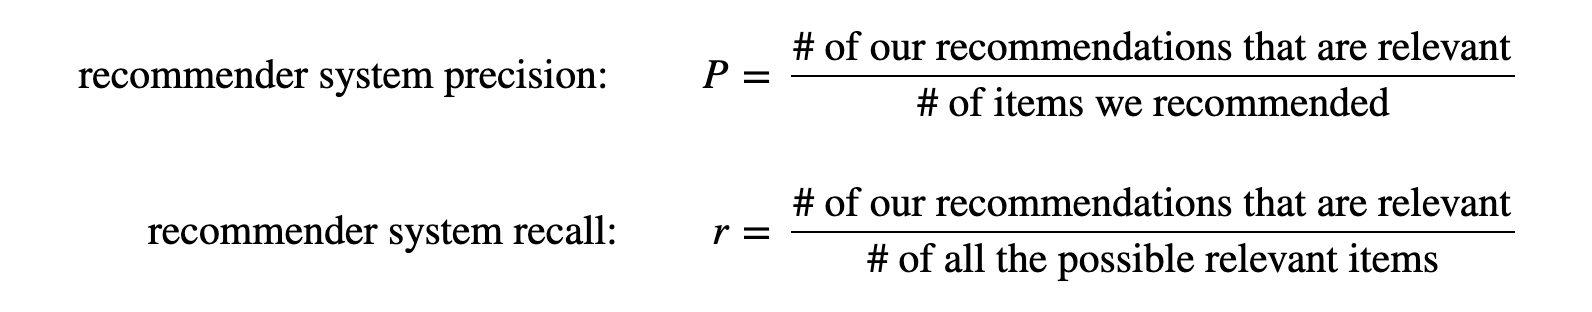

In [ ]:
def calculate_precision_at_k(relevant_recommendations_count, recommended_count):
  return relevant_recommendations_count / recommended_count

def calculate_recall_at_k(relevant_recommendations_count, all_possible_relevant_recommendations_count):
  return relevant_recommendations_count / all_possible_relevant_recommendations_count

def calculate_f1_score_at_k(precision, recall):
  return 2 * (precision * recall) / (precision + recall)

# ---
def get_formatted_output_line(title, result):
  return '{:>12}  {:>12}'.format(title, result)

In [ ]:
reference_item = "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948"

lists_of_trait_content_based_recommendations, cosine_sim_of_trait_content_based_recommendations = content_based_recommendations(reference_item)
lists_of_trait_rarity_based_recommendations, total_rarity_of_trait_rarity_based_recommendations = trait_rarity_recommendations(reference_item)

list_of_all_recommendations = lists_of_trait_rarity_based_recommendations + lists_of_trait_content_based_recommendations
unique_set_of_all_recommendations = set(list_of_all_recommendations)


In [ ]:
evaluation_dict = {} # will be helpful to show comparison graphs

# relevant_recommendations_count = 10
# recommended_count = 10
# relevant_recommendations_count = 10 # this will vary depending on the similarity of the output from the two models
# all_possible_relevant_recommendations_count = 20 # this can be 20 or more because each model will give different outputs (trait_rarity & trait_content)
#  actually these two models can't be compared here because trait rarity is not directly related to trait content, but we can check how 
#   normal content based filtering differs from social trends based filtering


#  ----- evaluate trait content based recommender - self scored
print("----- Evaluation of Trait Content based Recommender (self-scored) -----")
relevant_recommendations_count = len(lists_of_trait_content_based_recommendations)
recommended_count = len(lists_of_trait_content_based_recommendations)
all_possible_relevant_recommendations_count = 10

precision_at_k = calculate_precision_at_k(relevant_recommendations_count, recommended_count)
recall_at_k = calculate_recall_at_k(relevant_recommendations_count, all_possible_relevant_recommendations_count)
f1_score_at_k = calculate_f1_score_at_k(precision_at_k, recall_at_k)

print(get_formatted_output_line("precision@k", precision_at_k))
print(get_formatted_output_line("recall@k", recall_at_k))
print(get_formatted_output_line("f1_score@k", round(f1_score_at_k, 2)))
print("\n")

#  ----- evaluate trait content based recommender - combined scored
print("----- Evaluation of Trait Content based Recommender (combined scored) -----")
relevant_recommendations_count = len(lists_of_trait_content_based_recommendations)
recommended_count = len(lists_of_trait_content_based_recommendations)
# all_possible_relevant_recommendations_count = 20
all_possible_relevant_recommendations_count = len(unique_set_of_all_recommendations)

precision_at_k = calculate_precision_at_k(relevant_recommendations_count, recommended_count)
recall_at_k = calculate_recall_at_k(relevant_recommendations_count, all_possible_relevant_recommendations_count)
f1_score_at_k = calculate_f1_score_at_k(precision_at_k, recall_at_k)

print(get_formatted_output_line("precision@k", precision_at_k))
print(get_formatted_output_line("recall@k", recall_at_k))
print(get_formatted_output_line("f1_score@k", round(f1_score_at_k, 2)))
print("\n")

#  ----- evaluate trait rarity based recommender (self-scored)
print("----- Evaluation of Trait Rarity based Recommender (self-scored) -----")
relevant_recommendations_count = len(lists_of_trait_rarity_based_recommendations)
recommended_count = len(lists_of_trait_rarity_based_recommendations)
all_possible_relevant_recommendations_count = 10

precision_at_k = calculate_precision_at_k(relevant_recommendations_count, recommended_count)
recall_at_k = calculate_recall_at_k(relevant_recommendations_count, all_possible_relevant_recommendations_count)
f1_score_at_k = calculate_f1_score_at_k(precision_at_k, recall_at_k)

print(get_formatted_output_line("precision@k", precision_at_k))
print(get_formatted_output_line("recall@k", recall_at_k))
print(get_formatted_output_line("f1_score@k", round(f1_score_at_k, 2)))
print("\n")

#  ----- evaluate trait rarity based recommender (combined-scored)
print("----- Evaluation of Trait Rarity based Recommender (combined-scored) -----")
relevant_recommendations_count = len(lists_of_trait_rarity_based_recommendations)
recommended_count = len(lists_of_trait_rarity_based_recommendations)
all_possible_relevant_recommendations_count = len(list_of_all_recommendations)

precision_at_k = calculate_precision_at_k(relevant_recommendations_count, recommended_count)
recall_at_k = calculate_recall_at_k(relevant_recommendations_count, all_possible_relevant_recommendations_count)
f1_score_at_k = calculate_f1_score_at_k(precision_at_k, recall_at_k)

print(get_formatted_output_line("precision@k", precision_at_k))
print(get_formatted_output_line("recall@k", recall_at_k))
print(get_formatted_output_line("f1_score@k", round(f1_score_at_k, 2)))
# print("\n")


----- Evaluation of Trait Content based Recommender (self-scored) -----
 precision@k           1.0
    recall@k           1.0
  f1_score@k           1.0


----- Evaluation of Trait Content based Recommender (combined scored) -----
 precision@k           1.0
    recall@k           0.5
  f1_score@k          0.67


----- Evaluation of Trait Rarity based Recommender (self-scored) -----
 precision@k           1.0
    recall@k           1.0
  f1_score@k           1.0


----- Evaluation of Trait Rarity based Recommender (combined-scored) -----
 precision@k           1.0
    recall@k           0.5
  f1_score@k          0.67


The reason to consider combined score seperately is because both the recommenders acrtually give relevant recommendations, but we need to show a user the best possible recommendations at the top.
Even if a weighted bias is used, we need data (that is not available at present) to define what weightage to give to each pipeline.

Therefore, it was decided to design the system in a way that allows a user to choose a relavant bias. This is updated for all users who don't choose a bias based on everyone else's selection.

Apply the above evaluation metrics for multiple recommendations and graphically represent them (AOC RUC curve??

***It doesn't have to be a rating but in order to evaluate the recommendation you need to know some information about the user's preferences.)***

This data is not currently available. We can use owners to find connections, but it won't give us every possible option. ...


Mean Average Precision can also be calculated only for items that have user-reviews? We need a personalized relationship to measure these.

### Evaluation of Diversity in generated Recommendations

In [ ]:
# difference (diversity) in recommendations using both methods for the same item, to generate recommendations

# bar chart to show uniqueness in recommendations

# show how difference the two are placed in opposite charts 
# >> (cosine sim chart for trend_scores, trend scores for content similarity)

In [ ]:
# graph representation of precisoin@k, recall@k - check if this makes sense

In [ ]:
def get_cosine_sim(initial_reference, item_reference_id):
    # getting the index of the initial NFT that was used for recommendations
    initial_idx = indices[indices == initial_reference].index[0]
    recommended_idx = indices[indices == item_reference_id].index[0]

    return cosine_sim[initial_idx][recommended_idx]

In [ ]:
def get_total_rarity_score(item_reference_id):
    return df.loc[item_reference_id]['total_rarity']

In [ ]:
# define this at the top, before getting recommendations

main_reference_item = "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948"

### Cosine similarity representation graph for all the recommended items (trait content + rarity recommendation models)

TODO: add axis labels & name graph

In [ ]:
cosine_sim_of_trait_rarity_based_recommendations = []
for trait_rarity_rec in lists_of_trait_rarity_based_recommendations:
  cosine_sim_of_trait_rarity_based_recommendations.append(get_cosine_sim(main_reference_item, trait_rarity_rec))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style

# style.use('fivethirtyeight')

import seaborn as sns

In [ ]:
trait_content_based_xs = lists_of_trait_content_based_recommendations
trait_content_based_ys = cosine_sim_of_trait_content_based_recommendations

# plot those from opposite recommendation models in a different colour
trait_rarity_based_xs = lists_of_trait_rarity_based_recommendations
trait_rarity_based_ys = cosine_sim_of_trait_rarity_based_recommendations

In [ ]:
print(trait_content_based_ys)
print(trait_rarity_based_ys)

[0.5714285714285713, 0.5714285714285713, 0.5714285714285713, 0.5714285714285713, 0.5714285714285713, 0.5714285714285713, 0.5345224838248487, 0.50709255283711, 0.50709255283711, 0.50709255283711]
[0.0, 0.0, 0.0, 0.1543033499620919, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714285714282]


* have xs as name of NFT
* ys as cosine_sim or trait_rarity

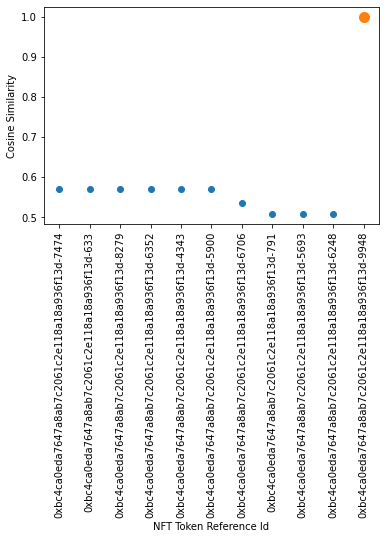

In [ ]:
# visualizing data
plt.scatter(trait_content_based_xs, trait_content_based_ys)

# plot the point of the initial reference item used - this will be close to 1 for content similarity
cosine_sim_main_reference_item = get_cosine_sim(main_reference_item, main_reference_item)
plt.scatter(main_reference_item, cosine_sim_main_reference_item, s=100)

# plt.scatter(trait_rarity_based_xs, trait_rarity_based_ys, color='g')

plt.xticks(rotation=90)

# plt.title("Cosine Similarities of Recommended NFTs - Trait Content Based Recomendations Model")
plt.xlabel("NFT Token Reference Id")
plt.ylabel("Cosine Similarity")

plt.show()

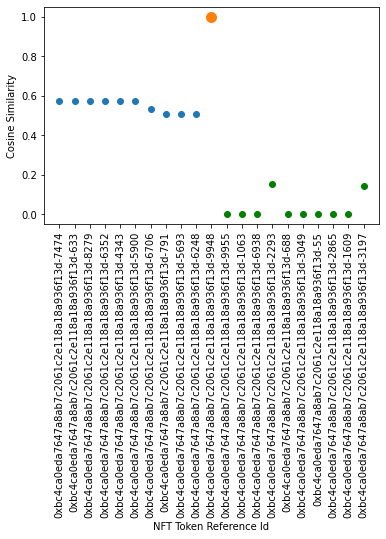

In [ ]:
# visualizing data
plt.scatter(trait_content_based_xs, trait_content_based_ys)

# plot the point of the initial reference item used - this will be close to 1 for content similarity
cosine_sim_main_reference_item = get_cosine_sim(main_reference_item, main_reference_item)
plt.scatter(main_reference_item, cosine_sim_main_reference_item, s=100)

plt.scatter(trait_rarity_based_xs, trait_rarity_based_ys, color='g')

plt.xticks(rotation=90)

# plt.title("Cosine Similarities of Recommended NFTs - Trait Content Based + Total Rarity Recomendations Models")
plt.xlabel("NFT Token Reference Id")
plt.ylabel("Cosine Similarity")

plt.show()

### Trait rarity representation graph for all the recommended items (trait content + rarity recommendation models)

In [ ]:
trait_rarity_of_content_based_recommendations = []
for trait_content_rec_reference_id in lists_of_trait_content_based_recommendations:
  trait_rarity_of_content_based_recommendations.append(get_total_rarity_score(trait_content_rec_reference_id))

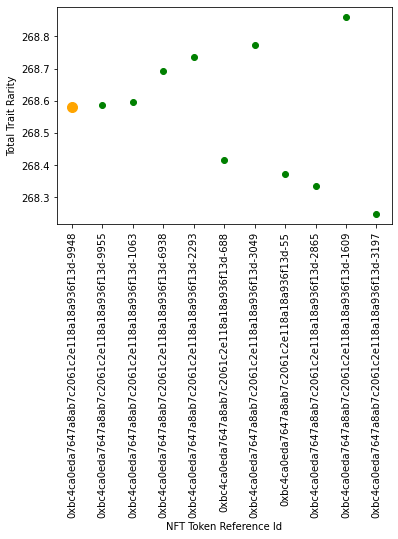

In [ ]:
# have xs as name of NFT
# ys as cosine_sim or trait_rarity

trait_content_based_xs = lists_of_trait_content_based_recommendations
trait_content_based_ys = trait_rarity_of_content_based_recommendations

# plot those from opposite recommendation models in a different colour
trait_rarity_based_xs = lists_of_trait_rarity_based_recommendations
trait_rarity_based_ys = total_rarity_of_trait_rarity_based_recommendations

# visualizing data
# plt.scatter(trait_content_based_xs, trait_content_based_ys)

# plot the point of the initial reference item used - this will be close to 1 for content similarity
total_trait_rarity_main_reference_item = get_total_rarity_score(main_reference_item)
plt.scatter(main_reference_item, total_trait_rarity_main_reference_item, s=100, color='orange')

plt.scatter(trait_rarity_based_xs, trait_rarity_based_ys, color='g')

plt.xticks(rotation=90)

# plt.title("Total Trait Rarities of Recommended NFTs - Total Rarity Recomendations Model")
plt.xlabel("NFT Token Reference Id")
plt.ylabel("Total Trait Rarity")

plt.show()

In [ ]:
print(trait_content_based_ys)
print(trait_rarity_based_ys)

[206.17198182705675, 123.01885345880706, 115.62480729908438, 176.26966965686734, 241.2949254419761, 318.5817712912088, 246.05309533101524, 120.80261326531654, 81.61671393150345, 82.24413473455752]
[268.5869483628186, 268.5956102194119, 268.69320516662947, 268.7376417146105, 268.4151140320821, 268.77389442436754, 268.3728638193646, 268.33485238639184, 268.86176385353434, 268.2467611254324]


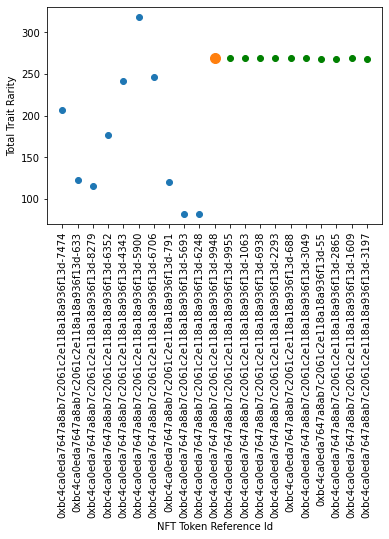

In [ ]:
# visualizing data
plt.scatter(trait_content_based_xs, trait_content_based_ys)

# plot the point of the initial reference item used - this will be close to 1 for content similarity
total_trait_rarity_main_reference_item = get_total_rarity_score(main_reference_item)
plt.scatter(main_reference_item, total_trait_rarity_main_reference_item, s=100)

plt.scatter(trait_rarity_based_xs, trait_rarity_based_ys, color='g')

plt.xticks(rotation=90)

# plt.title("Total Trait Rarities of Recommended NFTs - Trait Content Based + Total Rarity Recomendations Models")
plt.xlabel("NFT Token Reference Id")
plt.ylabel("Total Trait Rarity")

plt.show()

### Diversity in Recommendations produced by the two models, for multiple recommendations

In [ ]:
diversity_items_dict = {}
similarity_items_dict = {}

def calculate_diversity_in_recommendations(reference_item):
  lists_of_trait_content_based_recommendations, _ = content_based_recommendations(reference_item)
  lists_of_trait_rarity_based_recommendations, _ = trait_rarity_recommendations(reference_item)

  list_of_all_recommendations = lists_of_trait_rarity_based_recommendations + lists_of_trait_content_based_recommendations
  unique_set_of_all_recommendations = set(list_of_all_recommendations)

  similarity = len(list_of_all_recommendations) - len(unique_set_of_all_recommendations)
  diversity = len(unique_set_of_all_recommendations)

  similarity_items_dict[reference_item] = similarity
  diversity_items_dict[reference_item] = diversity

for index, row in df.iterrows():
  reference_item = index
  calculate_diversity_in_recommendations(reference_item)

In [ ]:
len(diversity_items_dict)

10000

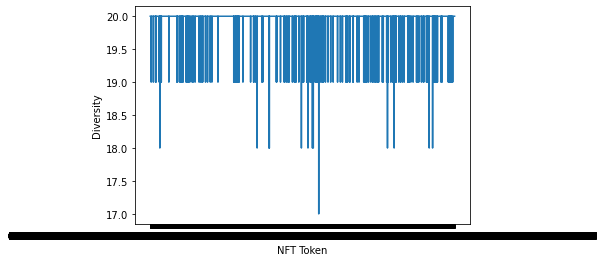

In [ ]:
# reference: https://stackoverflow.com/a/37266356/11005638

lists = sorted(diversity_items_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

plt.xlabel("NFT Token")
plt.ylabel("Diversity")

plt.show()

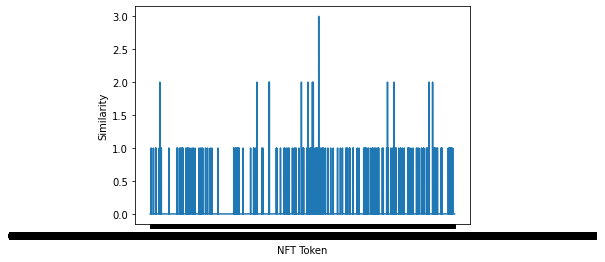

In [ ]:
lists = sorted(similarity_items_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)

plt.xlabel("NFT Token")
plt.ylabel("Similarity")

plt.show()

# Test Functions

In [ ]:
# get_cosine_sim("0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-9948", "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d-7474")